## Characteristic Reconstruction

In [2]:
from sympy import *
init_printing(use_unicode=True)

### Conserved variables
We start with the Euler equations in conservation-law form, with the vector of conserved variables $U$ and primitive variables $q$. Then we compute the $P$ matrix ($P_{ij} = \partial U_i / \partial q_j$) and the $Q_x$ matrix ($Q_{k,ij} = \partial F_{k,i} / \partial q_j$, where $F_k$ is the flux vector in the $k$ direction) (Sutherland and Kennedy, 2002). ($F$ denotes the fluxes of the conserved variables.)

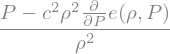

In [3]:
# define symbols
rho = Symbol('rho', positive=True) # density
p = Symbol('P', positive=True) # pressure
u = Symbol('u') # normal velocity
v = Symbol('v') # transverse velocity
w = Symbol('w') # transverse velocity
s = Symbol('s') # passive scalar
c = Symbol('c') # sound speed
e = Function('e')(rho, p) # specific internal energy

E = rho*e + rho*(u**2 + v**2 + w**2)/2 # total energy density

# (this is needed to rewrite the thermodynamic derivatives in terms of the sound speed)
de_drho = solveset(Eq(c**2, (p - rho**2 * Derivative(e, rho)) / (rho**2 * Derivative(e,p))), Derivative(e, rho)).args[0]
de_drho

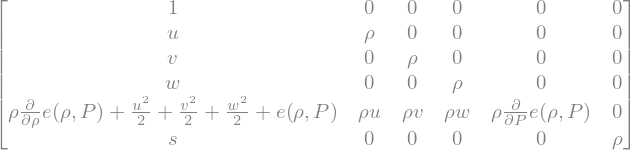

In [4]:
# compute the P matrix from Sutherland and Kennedy (2003)
U = Matrix([rho, rho*u, rho*v, rho*w, E, rho*s])
q = Matrix([rho, u, v, w, p, s])
P = simplify(Matrix(BlockMatrix(Derivative(U, q, evaluate=True).T)).T)
P

In [5]:
# compute the Q_n matrix
F_n = Matrix([rho*u,  # flux vector in normal direction
            rho*u**2 + p,
            rho*v*u,
            rho*w*u,
            (E + p)*u,
            rho*s*u])
Q_n = simplify(Matrix(BlockMatrix(Derivative(F_n, q, evaluate=True).T)).T)

### Primitive variables
Now we compute the coefficient matrix $A_x$ for the primitive equations ($A = P^{-1} Q$):

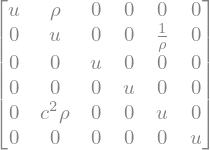

In [6]:
# compute the A_n matrix from Sutherland and Kennedy (2003)
# (this is the primitive variable flux matrix in the normal direction)
A_n = simplify(Inverse(P) * Q_n).subs(Derivative(e,rho), de_drho)
A_n

### Characteristic variables
We compute the eigenvalues $\lambda$ and eigenvectors $S$ of the $A_x$ matrix.

Then we compute the vector $\mathcal{L} = \lambda S^{-1} \frac{dq}{dx}$.

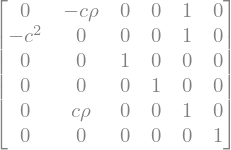

In [7]:
# compute the eigenvector matrix S
c = Symbol('c')
rho = Symbol('rho')
lambda_list = [eval for (eval, n, es) in A_n.left_eigenvects()]
Sinv_list = [[ev for ev in es] for (v, n, es) in A_n.left_eigenvects()]
Sinv = Matrix([Sinv_list[1][0],  Sinv_list[0][2], Sinv_list[0][0], Sinv_list[0][1], Sinv_list[2][0], Sinv_list[0][3]])
Sinv

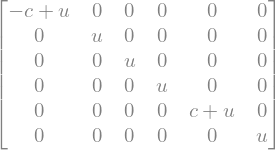

In [8]:
# compute eigenvalue matrix \lambda
lambda_waves = diag(lambda_list[1], lambda_list[0], lambda_list[0], lambda_list[0], lambda_list[2], lambda_list[0])
lambda_waves

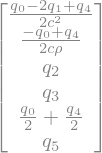

In [39]:
# compute S*qhat
S = Sinv.inv()
q0 = Symbol('q0')
q1 = Symbol('q1')
q2 = Symbol('q2')
q3 = Symbol('q3')
q4 = Symbol('q4')
q5 = Symbol('q5')
qhat = Matrix([q0, q1, q2, q3, q4, q5])
qp = simplify(S*qhat)
qp

In [37]:
common_exprs_lower, final_expr_lower = cse(qp, list=False)
for var, val in common_exprs_lower:
    print(cxxcode(val, assign_to=var))
print(cxxcode(final_expr_lower, assign_to='charVars'))

charVars[0] = (1.0/2.0)*(q0 - 2*q1 + q4)/std::pow(c, 2);
charVars[1] = (1.0/2.0)*(-q0 + q4)/(c*rho);
charVars[2] = q2;
charVars[3] = q3;
charVars[4] = (1.0/2.0)*q0 + (1.0/2.0)*q4;
charVars[5] = q5;


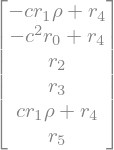

In [41]:
r0 = Symbol('r0')
r1 = Symbol('r1')
r2 = Symbol('r2')
r3 = Symbol('r3')
r4 = Symbol('r4')
r5 = Symbol('r5')
rhat = Matrix([r0, r1, r2, r3, r4, r5])
rp = simplify(Sinv*rhat)
rp

In [42]:
common_exprs_lower, final_expr_lower = cse(rp, list=False)
for var, val in common_exprs_lower:
    print(cxxcode(val, assign_to=var))
print(cxxcode(final_expr_lower, assign_to='primVars'))

x0 = -r4;
x1 = c*r1*rho;
primVars[0] = -x0 - x1;
primVars[1] = -std::pow(c, 2)*r0 - x0;
primVars[2] = r2;
primVars[3] = r3;
primVars[4] = r4 + x1;
primVars[5] = r5;
